In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import json 
import random 
from warnings import filterwarnings
filterwarnings('ignore')
import math
from datetime import datetime


In [64]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [65]:
config = json.loads(open('config.json').read()) 
cifar_model_path = config["local"]["model_path"]
train= True
save_model = True


In [66]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Data Augmentation and Rescaling for Training and Validation Sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1./255)  # Just rescaling for validation data
test_datagen = ImageDataGenerator(rescale=1./255)


# Create Training Set Generator
train_set = train_datagen.flow(
    x_train, y_train,        # Path to the folder containing training images     # Resize images to 150x150
    batch_size=32,                   # Process 32 images per batch
) 

val_set = val_datagen.flow(
    x_val, y_val, 
    batch_size=32
)

test_set = test_datagen.flow(
    x_test, y_test, 
    batch_size=32
)

In [27]:


# Define the CNN Model
classifier = Sequential([
    Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # Use sigmoid for binary classification
])

In [60]:
# Compile the Model
classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
early_stopping = True
if early_stopping:
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
else:
    early_stopping = None

steps_per_epoch = math.ceil(x_train.shape[0] / train_set.batch_size)

# If you have a validation set, calculate validation steps in the same way
validation_steps = math.ceil(x_val.shape[0] / val_set.batch_size)

# Train the Model
history = classifier.fit(
    train_set,
    steps_per_epoch=steps_per_epoch,
    epochs=200,
    validation_data=val_set,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)
    



Epoch 1/200
 73/640 [==>...........................] - ETA: 17s - loss: 2.2560 - accuracy: 0.1284

KeyboardInterrupt: 

### Prediction of Single Image

1/1 [==============================] - 0s 33ms/step
Predicted Label: 9
True Label: [0]


Text(0, 0, 'Predicted Label: 9')

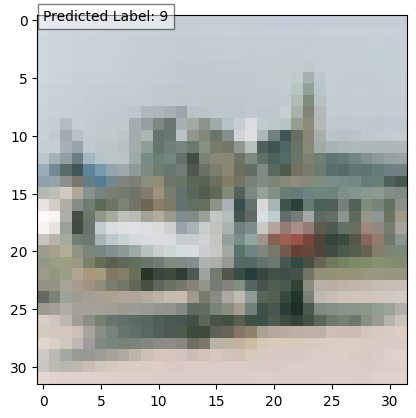

In [44]:
#get random image from train_set_folder
all_files = []
random_int= random.randint(0, x_train.shape[0]) 
to_plot= x_train[random_int]
label= y_train[random_int]
to_plot = np.expand_dims(to_plot, axis=0)
# Make prediction
prediction = classifier.predict(to_plot)  # No need for batch_size or steps arguments
predicted_label = np.argmax(prediction)
print(f"Predicted Label: {predicted_label}")
print(f"True Label: {label}")
plt.imshow(to_plot[0])
plt.text(0, 0, f"Predicted Label: {predicted_label}", bbox=dict(facecolor='white', alpha=0.5))



In [53]:
# Reset the generator before prediction
val_set.reset()
steps  = math.ceil(x_val.shape[0] / val_set.batch_size)
# Use predict with steps argument
predictions = classifier.predict(val_set, steps=steps)
df = pd.DataFrame({
    'predict': predictions.argmax(axis=1),
    'y': y_val.flatten()
})


160/160 [==============================] - 2s 13ms/step


In [56]:
misclassified = df[df['y']!=df['predict']]
print('Total misclassified image from 5000 Validation images : %d'%misclassified['y'].count())

Total misclassified image from 5000 Validation images : 4582


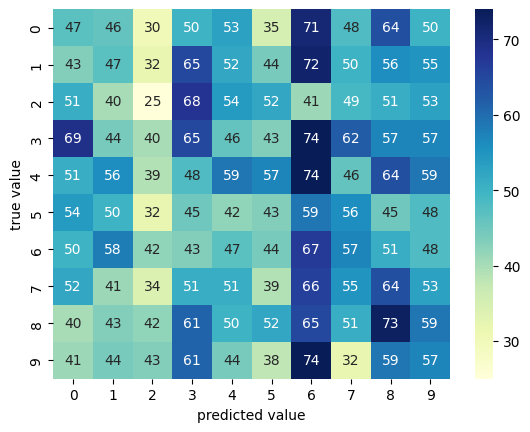

In [58]:
conf_matrix = confusion_matrix(df.y,df.predict)
sns.heatmap(conf_matrix,cmap="YlGnBu",annot=True,fmt='g');
plt.xlabel('predicted value')
plt.ylabel('true value');

## New model for Cifar-10, based on VGG16 architecture


Redefine Model using: 
1) Additional layers to add robustness to the model
2) Normalisation for model stability
3) Additional dropout to prevent overfitting

In [67]:
from tensorflow.keras.layers import Dropout

classifier = Sequential([
    # First block (2 convolutional layers + max pooling)
    Conv2D(64, (3, 3), padding='same', input_shape=(32, 32, 3), activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Second block (2 convolutional layers + max pooling)
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Third block (3 convolutional layers + max pooling)
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Fourth block (3 convolutional layers + max pooling)
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Fifth block (3 convolutional layers + max pooling)
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    Conv2D(512, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flattening and Fully Connected Layers
    Flatten(),
    Dense(4096, activation='relu'),
    Dropout(0.5),  # Dropout layer to reduce overfitting
    Dense(4096, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # Output layer with 10 classes (for CIFAR-10)
])

# Compile the Model
classifier.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
early_stopping = True
if early_stopping:
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
else:
    early_stopping = None

steps_per_epoch = math.ceil(x_train.shape[0] / train_set.batch_size)

# If you have a validation set, calculate validation steps in the same way
validation_steps = math.ceil(x_val.shape[0] / val_set.batch_size)

# Train the Model
history = classifier.fit(
    train_set,
    steps_per_epoch=steps_per_epoch,
    epochs=200,
    validation_data=val_set,
    validation_steps=validation_steps,
    callbacks=[early_stopping]
)
    


Epoch 1/200
  19/1250 [..............................] - ETA: 12:11 - loss: 2.7307 - accuracy: 0.0066